# Property Selling Price Regression II with Ridge, LASSO, and Elastic Net, February 2018

# Introduction
* While nearing completion of my binary classification project, I looked back on my multiple regression project. I wanted to try out regression methods more advanced than simple multiple regression, and apply concepts that I know now that I was not familiar with last fall. In particular, I was eager to tackle a regression problem using regularization.
* I hacked this project together over the course of two days, experimenting for the first time with these 3 new methods: Ridge, LASSO, and Elastic Net. 
* Regularization is a method of penalizing variable coefficients to reduce bias in your model. Ridge utilizes L2 regularization and better handles multicollinearity among independent variables, and LASSO uses L1 regularization and performs variable importance selection. Elastic Net recovers both l2 and l1 regularization, essentially combining the two regression models.
* Data and data field descriptions for this popular Kaggle dataset: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import math
import warnings
import scipy.stats as stats

warnings.filterwarnings('ignore')

from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.base import TransformerMixin
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression


% matplotlib inline

In [2]:
df_train = pd.read_csv('/Users/jordanbauer/Data Mining Learning/Personal Projects/Multiple Regression/real_estate_train.csv')
df_original = pd.read_csv('/Users/jordanbauer/Data Mining Learning/Personal Projects/Multiple Regression/real_estate_train.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_train.set_index('Id', inplace=True)
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [5]:
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Data Preparation

In [6]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Sometimes categorical variables that have numeral values are mistakenly described as numerical by Pandas. We'll have to change those variables to be represented as categorical.

In [7]:
for var in df_train.columns:
    print('{0}: {1}'.format(var, df_train[var].dtype))

MSSubClass: int64
MSZoning: object
LotFrontage: float64
LotArea: int64
Street: object
Alley: object
LotShape: object
LandContour: object
Utilities: object
LotConfig: object
LandSlope: object
Neighborhood: object
Condition1: object
Condition2: object
BldgType: object
HouseStyle: object
OverallQual: int64
OverallCond: int64
YearBuilt: int64
YearRemodAdd: int64
RoofStyle: object
RoofMatl: object
Exterior1st: object
Exterior2nd: object
MasVnrType: object
MasVnrArea: float64
ExterQual: object
ExterCond: object
Foundation: object
BsmtQual: object
BsmtCond: object
BsmtExposure: object
BsmtFinType1: object
BsmtFinSF1: int64
BsmtFinType2: object
BsmtFinSF2: int64
BsmtUnfSF: int64
TotalBsmtSF: int64
Heating: object
HeatingQC: object
CentralAir: object
Electrical: object
1stFlrSF: int64
2ndFlrSF: int64
LowQualFinSF: int64
GrLivArea: int64
BsmtFullBath: int64
BsmtHalfBath: int64
FullBath: int64
HalfBath: int64
BedroomAbvGr: int64
KitchenAbvGr: int64
KitchenQual: object
TotRmsAbvGrd: int64
Function

In [8]:
df_train['OverallQual'] = df_train['OverallQual'].astype('object')
df_train['OverallCond'] = df_train['OverallCond'].astype('object')
df_train['YearBuilt'] = df_train['YearBuilt'].astype('object')
df_train['YearRemodAdd'] = df_train['YearRemodAdd'].astype('object')
df_train['YrSold'] = df_train['YrSold'].astype('object')
df_train['MoSold'] = df_train['MoSold'].astype('object')
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].astype('object')
df_train['MSSubClass'] = df_train['MSSubClass'].astype('object')

We'll also need to clean up any missing data.

In [9]:
def show_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    df = pd.concat([total, percent], axis=1, keys=['Count', '% Missing Data'])
    df = df[df['Count'] > 0]
    return df

missing_1 = show_missing(df_train)
missing_1

,Count,% Missing Data
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


Some of these values aren't actually missing, for instance a NaN for simply fence means there is no fence at this property. We'll set them equal to zero regardless of them being truly missing or just absent from the property. 

We'll set NaN values for garage year built to the median year (we'll come back to this approach later on).

In [10]:
def refactor_nans(df, variables):
    for var in variables:
        df[var].fillna(value=0, inplace=True)

refactor_nans(df_train, ['LotFrontage', 'MasVnrArea', 'PoolQC', 'Alley', 'Fence', 'MiscFeature', 'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'FireplaceQu', 'MasVnrType', 'BsmtFinType2', 'BsmtFinType1', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'Electrical'])
df_train['GarageYrBlt'].fillna(value=df_train['GarageYrBlt'].median(), inplace=True)

In [11]:
missing_2 = show_missing(df_train)
missing_2

,Count,% Missing Data


Some variables that describe age span over 100 years. We don't need a dummy variable for each year, so we'll bin these variables by decade.

In [12]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    df_train.loc[df_train[var] == 0, var] = 0
    df_train.loc[(df_train[var] > 0) & (df_train[var] < 1889), var] = 1
    df_train.loc[(df_train[var] >= 1890) & (df_train[var] < 1900), var] = 2
    df_train.loc[(df_train[var] >= 1900) & (df_train[var] < 1910), var] = 3
    df_train.loc[(df_train[var] >= 1910) & (df_train[var] < 1920), var] = 4
    df_train.loc[(df_train[var] >= 1920) & (df_train[var] < 1930), var] = 5
    df_train.loc[(df_train[var] >= 1930) & (df_train[var] < 1940), var] = 6
    df_train.loc[(df_train[var] >= 1940) & (df_train[var] < 1950), var] = 7
    df_train.loc[(df_train[var] >= 1950) & (df_train[var] < 1960), var] = 8
    df_train.loc[(df_train[var] >= 1960) & (df_train[var] < 1970), var] = 9
    df_train.loc[(df_train[var] >= 1970) & (df_train[var] < 1980), var] = 10
    df_train.loc[(df_train[var] >= 1980) & (df_train[var] < 1990), var] = 11
    df_train.loc[(df_train[var] >= 1990) & (df_train[var] < 2000), var] = 12
    df_train.loc[(df_train[var] >= 2000) & (df_train[var] < 2010), var] = 13
    df_train.loc[df_train[var] >= 2010, var] = 14
    df_train[var] = df_train[var].astype('object')

The "testing" file associated with this dataset does not truly come with true target values, thus it isn't really a testing set that we can use to measure our performance. We'll have to randomly generate our own training and testing sets. We'll also encode *all* of our categorical features into numeral representations.

In [13]:
categorical_feats = df_train.select_dtypes(include=["object"]).columns.tolist()
numerical_feats = df_train.select_dtypes(exclude=["object"]).columns.tolist()

for var in categorical_feats:
    df_train[var] = df_train[var].astype('category')
    df_train[var] = df_train[var].cat.codes
    df_train[var] = df_train[var].astype('object')

X, X_holdout, y, y_holdout = train_test_split(df_train.drop('SalePrice', axis=1), df_train['SalePrice'], test_size=0.25, random_state=10)
train = pd.concat([X, y], axis=1)

# Date Preparation and Preprocessing
Outliers can heavily corrupt the predictive power of our models. We'll eliminate values that don't clearly don't play along with the overall trend. Also, we have a great deal of zero values skewing our spreads that need our attention; a basement square footage variable is great, except for the properties that don't have basements. We can circumvent these by creating binary variables to describe the most extreme cases or refactor zeros to be the median of the distribution. We will also have to scale our variables to have zero mean and unit variance to set all numerical variables to the same scale, but we will likely have to perform log transformations on certain variables to achieve normal-ish distributions. Scaling will produce negative values, which can't be log transformed, so we will scale further down the road.

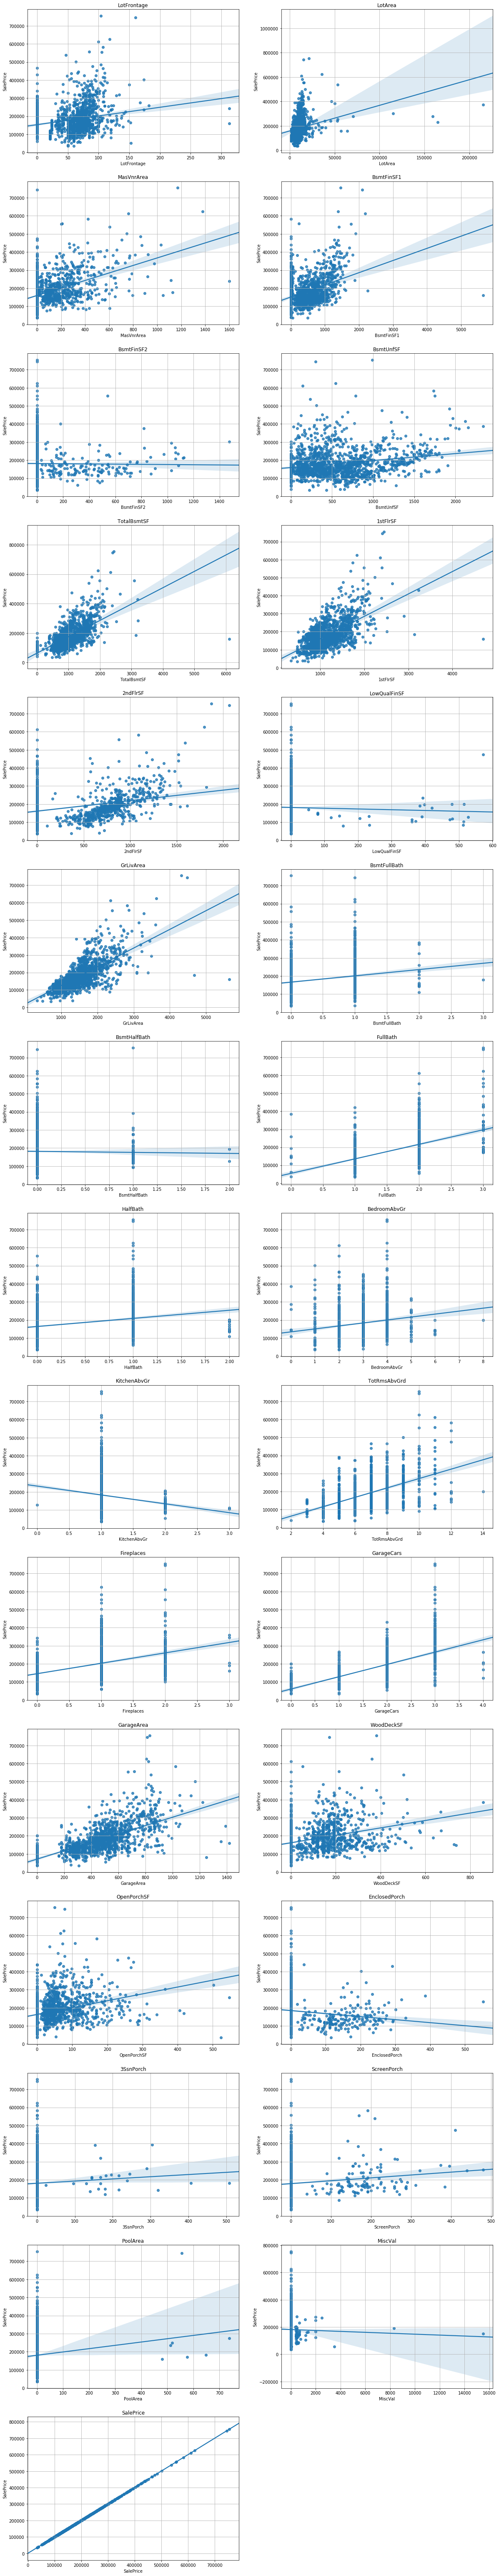

In [14]:
plt.figure(figsize=(20, 7.5*math.ceil(len(numerical_feats)/2)))
for i, var in enumerate(numerical_feats):
    plt.subplot(math.ceil(len(numerical_feats)/2), 2, i+1)
    plt.title(var)
    sns.regplot(data=df_train, x=var, y='SalePrice')
    plt.ylabel('SalePrice')
    plt.xlabel(var)
    plt.grid()

Now without zeros.

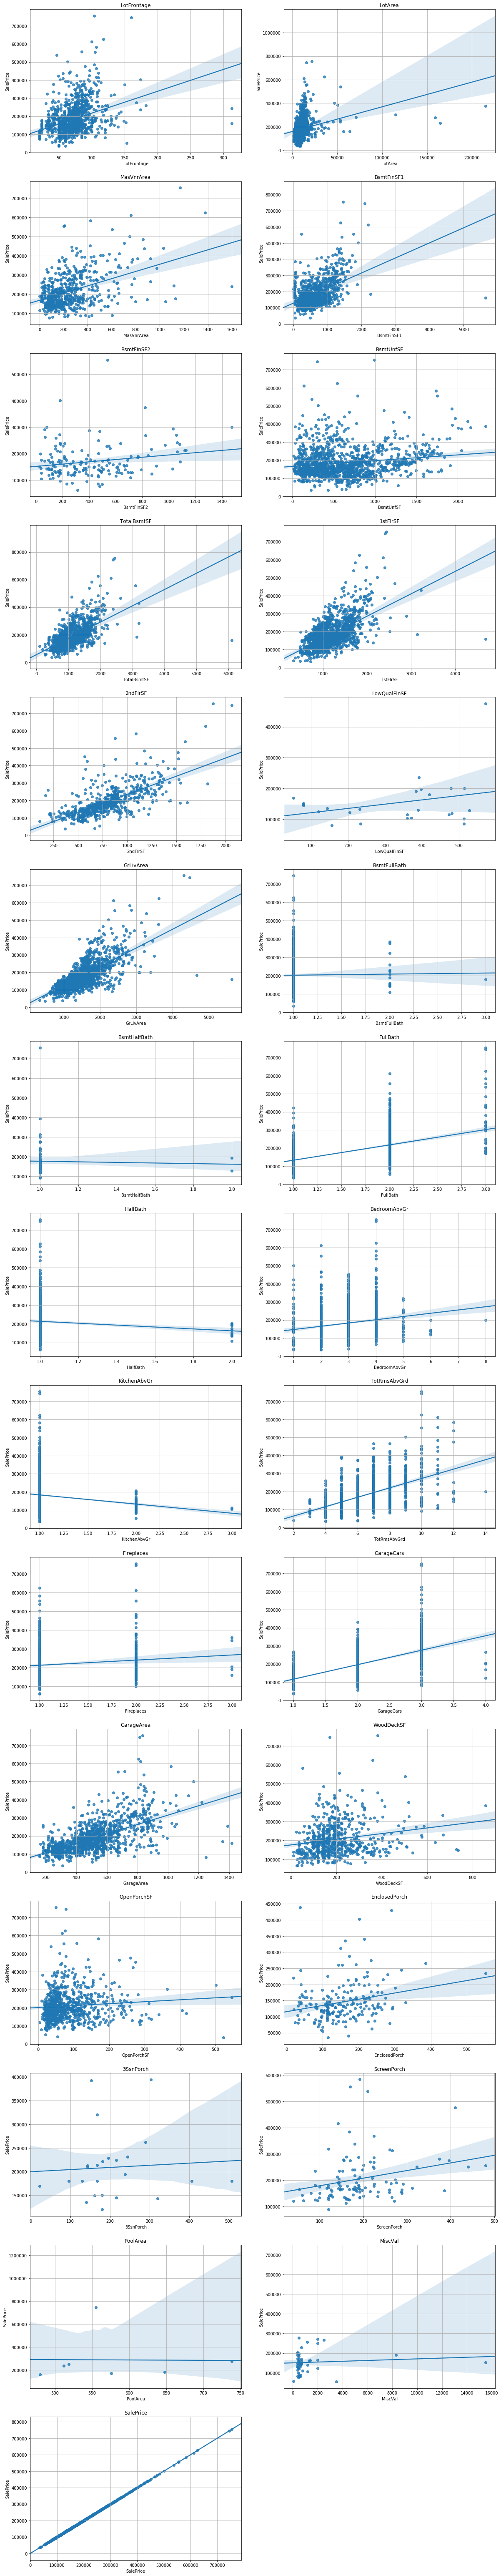

In [15]:
plt.figure(figsize=(20, 7.5*math.ceil(len(numerical_feats)/2)))
for i, var in enumerate(numerical_feats):
    plt.subplot(math.ceil(len(numerical_feats)/2), 2, i+1)
    plt.title(var)
    sns.regplot(data=df_train[df_train[var] != 0], x=var, y='SalePrice')
    plt.ylabel('SalePrice')
    plt.xlabel(var)
    plt.grid()

We can remove some obvious outliers that are swaying our regression lines. We'll also rework some of our variables into binary categorical variables, which may better describe those variables' relationship with sale price.

In [16]:
#Deleting outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4500) & (df_train['SalePrice'] < 300000)].index)
df_train = df_train.drop(df_train[(df_train['TotalBsmtSF'] > 5000) & (df_train['SalePrice'] < 200000)].index)
df_train = df_train.drop(df_train[(df_train['LotArea'] > 100000) & (df_train['SalePrice'] < 500000)].index)
df_train = df_train.drop(df_train[(df_train['BsmtFinSF1'] > 5000) & (df_train['SalePrice'] < 200000)].index)
df_train = df_train.drop(df_train[(df_train['1stFlrSF'] > 4000) & (df_train['SalePrice'] < 200000)].index)
df_train = df_train.drop(df_train[(df_train['LotFrontage'] > 300) & (df_train['SalePrice'] < 300000)].index)
df_train = df_train.drop(df_train[(df_train['MiscVal'] > 8000) & (df_train['SalePrice'] > 100000)].index)

In [17]:
df_train['HasPool'] = df_train['PoolArea'].where(df_train['PoolArea'] == 0, 1)
df_train['HasPool'] = df_train['HasPool'].astype('object')
df_train.drop(['PoolQC', 'PoolArea'], axis=1, inplace=True)
df_train['HasMiscFeature'] = df_train['MiscFeature'].where(df_train['MiscFeature'] == 1, 1)
df_train['HasMiscFeature'] = df_train['HasMiscFeature'].where(df_train['MiscFeature'] != 1, 0)
df_train['HasMiscFeature'] = df_train['HasMiscFeature'].astype('object')
df_train.drop(['MiscFeature', 'MiscVal'], axis=1, inplace=True)
df_train['Has3SsnPorch'] = df_train['3SsnPorch'].where(df_train['3SsnPorch'] == 0, 1)
df_train['Has3SsnPorch'] = df_train['Has3SsnPorch'].astype('object')
df_train.drop('3SsnPorch', axis=1, inplace=True)
df_train['HasBsmtFullBath'] = df_train['BsmtFullBath'].where(df_train['BsmtFullBath'] == 0, 1)
df_train['HasBsmtFullBath'] = df_train['HasBsmtFullBath'].astype('object')
df_train.drop('BsmtFullBath', axis=1, inplace=True)

In [18]:
categorical_feats = df_train.select_dtypes(include=["object"]).columns.tolist()
numerical_feats = df_train.select_dtypes(exclude=["object"]).columns.tolist()

X, X_holdout, y, y_holdout = train_test_split(df_train.drop('SalePrice', axis=1), df_train['SalePrice'], test_size=0.25, random_state=10)
train = pd.concat([X, y], axis=1)

We still have some more numerical variables that need attention, since scatter plots don't always tell the whole story of the distribution. Skewness/non-normal distributions in our variables will hurt our regression, so we'll need to identify those variables displaying skewness and apply transformations where necessary.

In [19]:
def skewness(df, variables):
    temp_dict = {}
    for var in variables:
        temp_dict[var] = df[var].skew()
    return pd.Series(temp_dict).sort_values()

train_skew = skewness(train, numerical_feats)

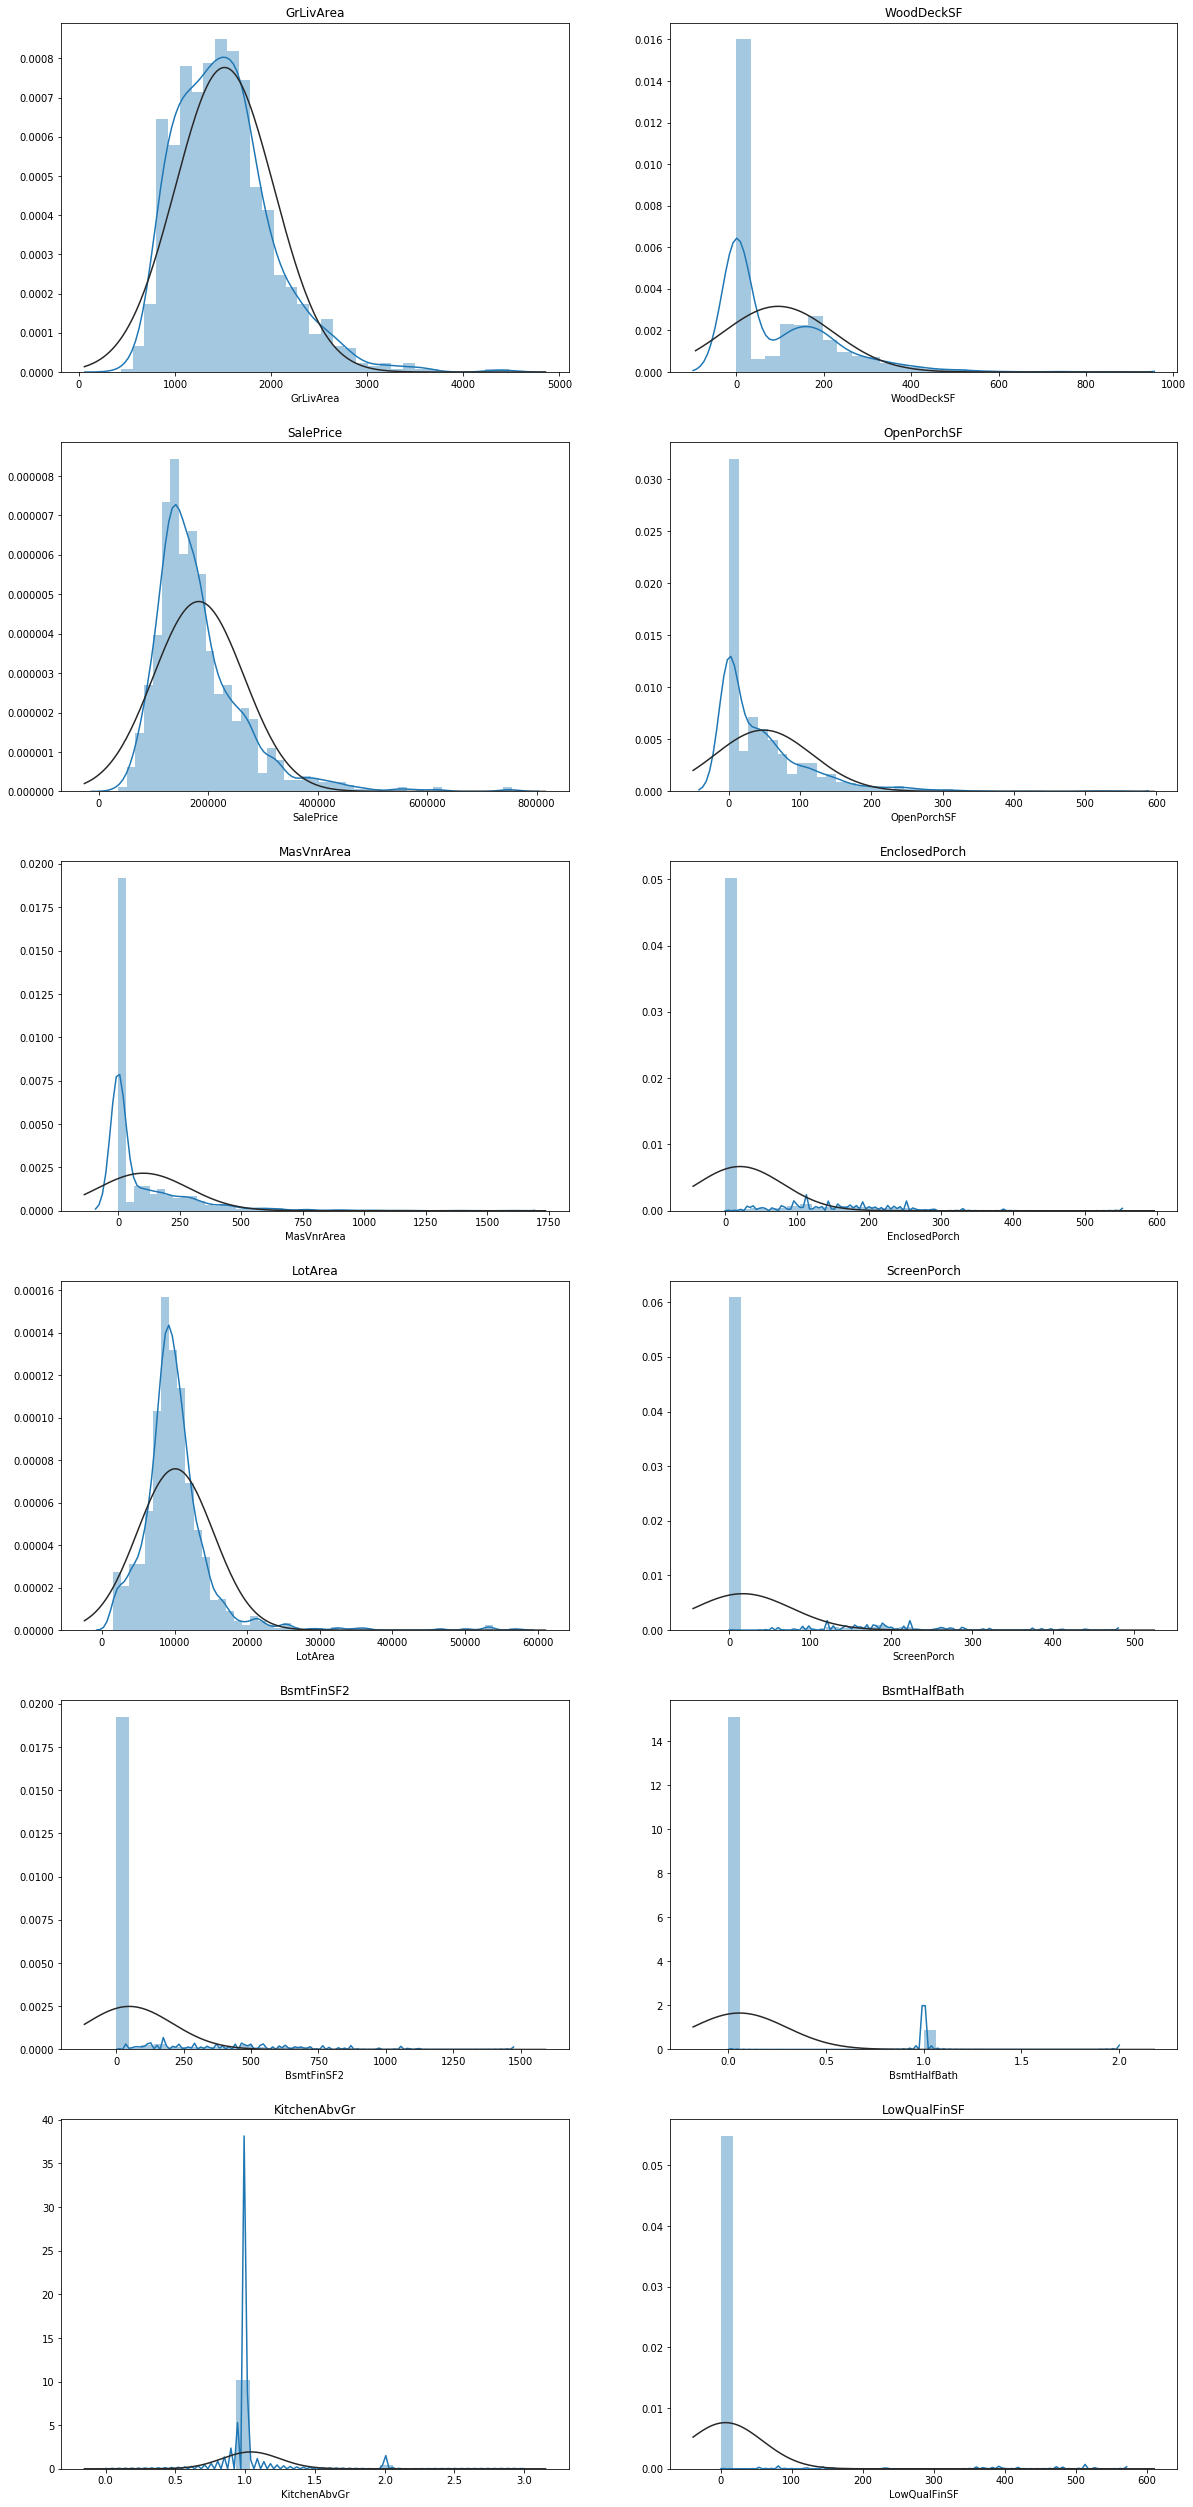

In [20]:
plt.figure(figsize=(20, 7.5*round(len(train_skew[train_skew > 1.0])/2)))
for i, var in enumerate(train_skew[train_skew > 1.0].sort_values().index):
    plt.subplot(math.ceil(len(train_skew[train_skew > 1.0])/2), 2, i+1)
    plt.title(var)
    sns.distplot(train[var], fit=stats.norm)

Our target variable "SalePrice" is also prominently lopsided.

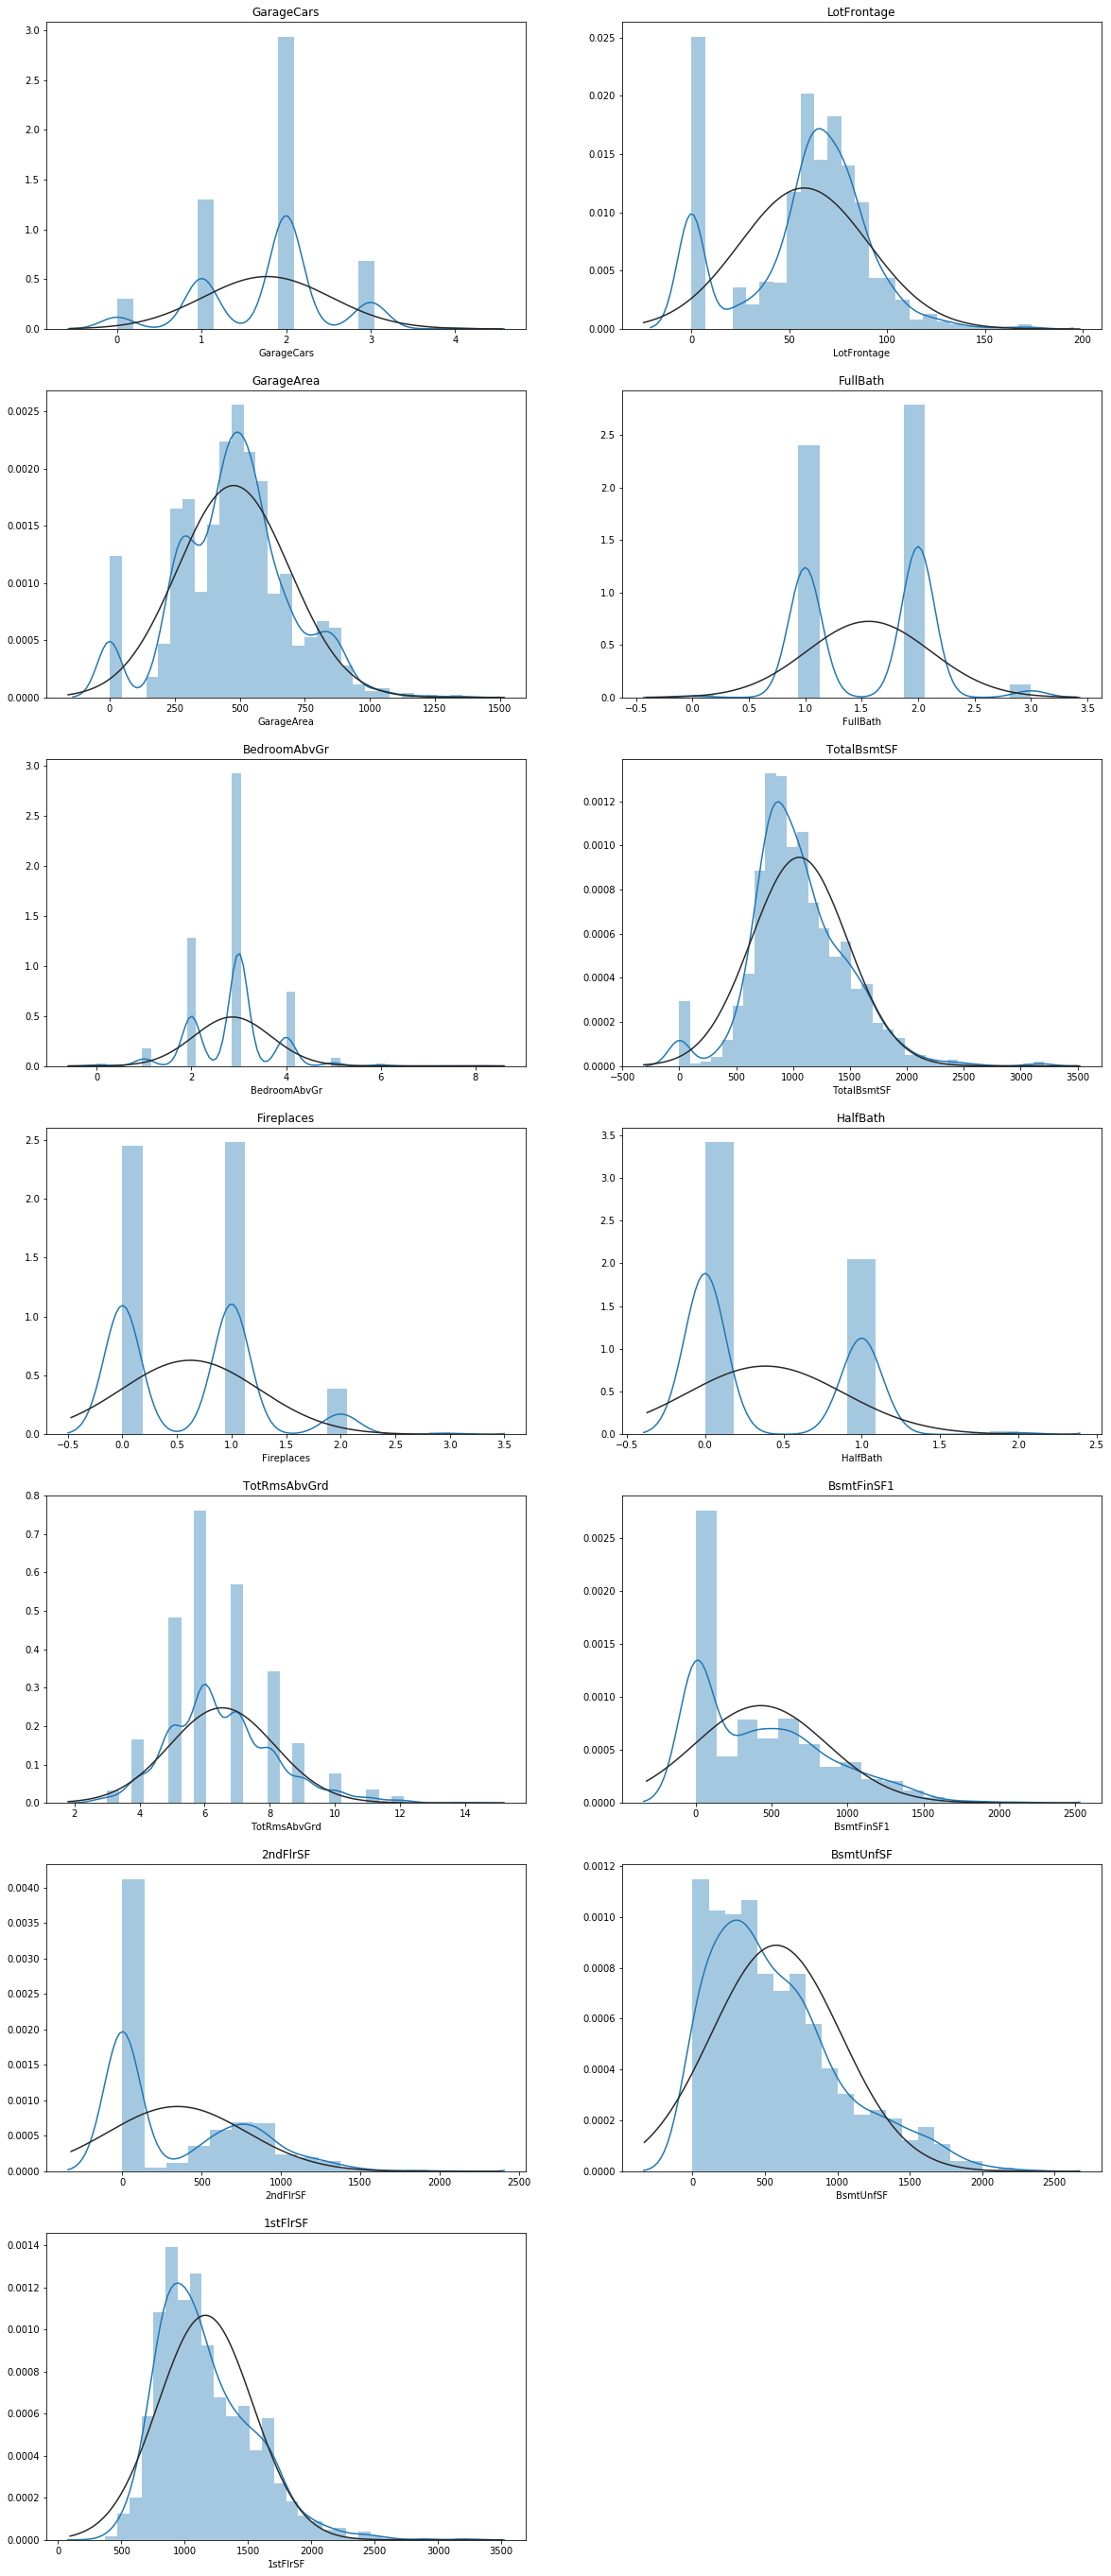

In [21]:
plt.figure(figsize=(20, 7*math.ceil(len(train_skew[train_skew < 1.0])/2)))
for i, var in enumerate(train_skew[train_skew < 1.0].index):
    plt.subplot(math.ceil(len(train_skew[train_skew < 1.0])/2), 2, i+1)
    plt.title(var)
    sns.distplot(train[var], fit=stats.norm)

We have some more variables that would be better suited/accompanied by binary variables, such as having a basement or a second floor. Some variables I think are better off only being binary, and other I think should be left continuous, with their zero values replaced by the median value of the distribution, *and* accompanied by a binary variable.

In [22]:
refactor_0s = ['OpenPorchSF', 'LotArea', '1stFlrSF', 'GrLivArea', 'TotalBsmtSF', 'BsmtUnfSF', 'GarageArea', 'LotFrontage', '2ndFlrSF']

In [23]:
df_train['HasLotFrontage'] = df_train['LotFrontage'].where(df_train['LotFrontage'] == 0, 1).astype('object')
df_train['Has2ndFlr'] = df_train['2ndFlrSF'].where(df_train['2ndFlrSF'] == 0, 1).astype('object')
df_train['HasGarage'] = df_train['GarageArea'].where(df_train['GarageArea'] == 0, 1).astype('object')
df_train['HasBsmt'] = df_train['TotalBsmtSF'].where(df_train['TotalBsmtSF'] == 0, 1).astype('object')
df_train['HasOpenPorch'] = df_train['OpenPorchSF'].where(df_train['OpenPorchSF'] == 0, 1).astype('object')
df_train['HasWoodDeck'] = df_train['WoodDeckSF'].where(df_train['WoodDeckSF'] == 0, 1).astype('object')
df_train.drop('WoodDeckSF', axis=1, inplace=True)
df_train['HasMasVnr'] = df_train['MasVnrArea'].where(df_train['MasVnrArea'] == 0, 1).astype('object')
df_train.drop('MasVnrArea', axis=1, inplace=True)
df_train['HasEnclosedPorch'] = df_train['EnclosedPorch'].where(df_train['EnclosedPorch'] == 0, 1).astype('object')
df_train.drop('EnclosedPorch', axis=1, inplace=True)
df_train['HasScreenPorch'] = df_train['ScreenPorch'].where(df_train['ScreenPorch'] == 0, 1).astype('object')
df_train.drop('ScreenPorch', axis=1, inplace=True)
df_train['HasLowQualFinSF'] = df_train['LowQualFinSF'].where(df_train['LowQualFinSF'] == 0, 1).astype('object')
df_train.drop('LowQualFinSF', axis=1, inplace=True)
df_train['MultKitchenAbvGr'] = df_train['KitchenAbvGr'].where(df_train['KitchenAbvGr'] < 2, 1).astype('object')
df_train.drop('KitchenAbvGr', axis=1, inplace=True)
df_train['HasBsmtHalfBath'] = df_train['BsmtHalfBath'].where(df_train['BsmtHalfBath'] == 0, 1).astype('object')
df_train.drop('BsmtHalfBath', axis=1, inplace=True)

In [24]:
categorical_feats = df_train.select_dtypes(include=["object"]).columns.tolist()
numerical_feats = df_train.select_dtypes(exclude=["object"]).columns.tolist()

X, X_holdout, y, y_holdout = train_test_split(df_train.drop('SalePrice', axis=1), df_train['SalePrice'], test_size=0.25, random_state=10)
train = pd.concat([X, y], axis=1)

We can use ANOVA to examine the significance of multivariate categorical variables and a simple t-test to examine binary variables.

In [25]:
def categorical_classes(df, variables):
    multi_vars = []
    binary_vars = []
    for var in df[variables]:
        if len(df[var].unique()) > 2:
            multi_vars.append(var)
        else:
            binary_vars.append(var)
    return (binary_vars, multi_vars)

t_vars, anova_vars = categorical_classes(train, categorical_feats)

In [26]:
anova = f_regression(train[anova_vars], train['SalePrice'])
anova_df = pd.DataFrame({'F': anova[0], 'P-value': anova[1].round(4)}, index=anova_vars)
anova_df[anova_df['P-value'] >= 0.05]

,F,P-value
MSSubClass,1.753982,0.1857
LandContour,0.859970,0.3540
LandSlope,0.882411,0.3478
Condition2,0.080654,0.7765
MasVnrType,0.585044,0.4445
BsmtFinType1,0.001313,0.9711
MoSold,2.029658,0.1545
YrSold,2.679567,0.1019


In [27]:
def t_test(df, target, variables, alpha=0.05):
    t_scores = []
    p_values = []
    for var in variables:
        t_temp = stats.ttest_1samp(df[df[var] == 1][target], df[df[var] == 0][target].median())
        t_scores.append(t_temp[0].round(2))
        p_values.append(t_temp[1].round(4))
    return (t_scores, p_values)

In [28]:
t = t_test(train, 'SalePrice', t_vars)
t_df = pd.DataFrame({'Feature T': t[0], 'P-Value': t[1]}, index=t_vars).sort_values('P-Value')
t_df[t_df['P-Value'] >= 0.05]

,Feature T,P-Value
HasPool,1.68,0.1681
HasBsmtHalfBath,1.06,0.2927
HasLowQualFinSF,-0.39,0.7016


In [29]:
drop_vars = t_df[t_df['P-Value'] >= 0.05].index.tolist() + anova_df[anova_df['P-value'] >= 0.05].index.tolist()
df_train.drop(drop_vars, axis=1, inplace=True)

Now it's time to wrap things up. We'll create dummy variables for our multiclass categorical features and redefine our train and test splits to have those dummy variables.

Let's take a look at our target variable and see if a log transformation will make it a little more normal.

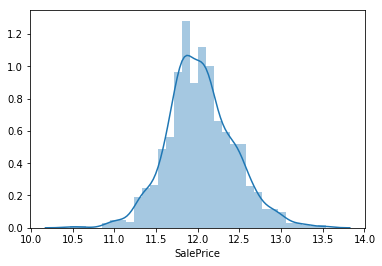

In [30]:
sns.distplot(np.log1p(y))

Success. Now our log transformed independent continuous variables, with their zeros replaced by the median of their distribution.

In [31]:
def log_0_transformer(df, variables):
    for var in variables:
        df[var] = np.log1p(df[var].where(df[var] != 0, df[var].median()))

log_0_transformer(X, refactor_0s)

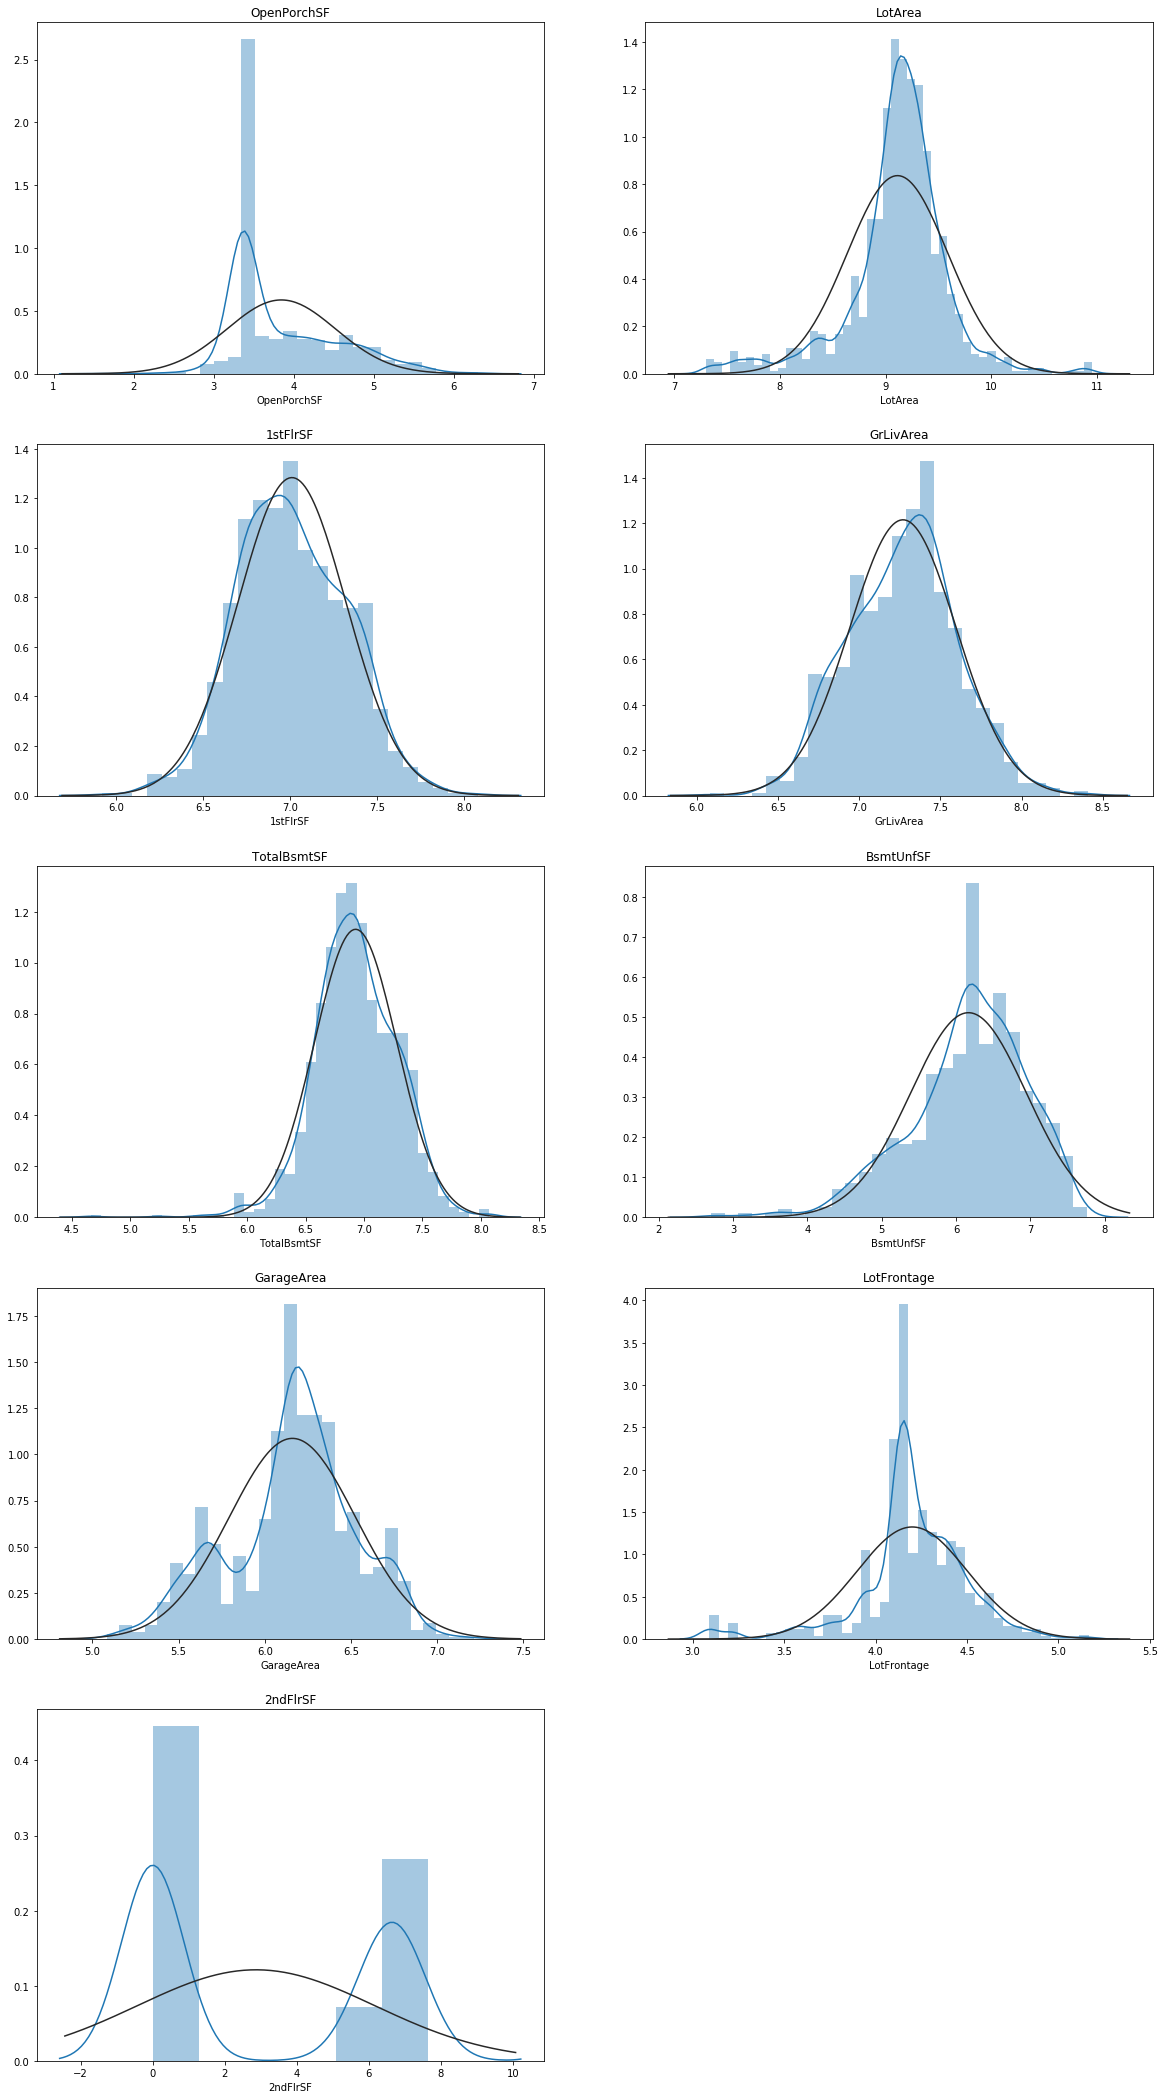

In [32]:
math.ceil(len(refactor_0s)/2)
plt.figure(figsize=(20, 7.5*math.ceil(len(refactor_0s)/2)))
for i, var in enumerate(refactor_0s):
    plt.subplot(math.ceil(len(refactor_0s)/2), 2, i+1)
    plt.title(var)
    sns.distplot(X[var], fit=stats.norm)

Our curves look a bit better than before. We still have extreme peakedness in some variables, but short of deleting a whole lot of zero values and suffer that information loss, I think we should be satisfied with their accompanying binary variables. Now it remains to standardize our datasets to a usable scale. This subtracts a variable's mean from its observations and divides them by their standard deviation, essential for certain linear models.

In [33]:
class CustomScaler(TransformerMixin): 
    def __init__(self, ignore_vars):
        self.scaler = RobustScaler()
        self.ignore_vars = ignore_vars

    def fit(self, X, y=None):
        self.scale_vars = X.drop(self.ignore_vars, axis=1).columns
        self.scaler.fit(X[self.scale_vars], y)
        return self

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.scale_vars]), columns=self.scale_vars, index=X.index)
        X_not_scaled = X[self.ignore_vars]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

class CustomNormalizer(TransformerMixin): 
    def __init__(self, ignore_vars):
        self.scaler = Normalizer()
        self.ignore_vars = ignore_vars

    def fit(self, X, y=None):
        self.scale_vars = X.drop(self.ignore_vars, axis=1).columns
        self.scaler.fit(X[self.scale_vars], y)
        return self

    def transform(self, X, y=None, copy=None):
        init_col_order = X.columns
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.scale_vars]), columns=self.scale_vars, index=X.index)
        X_not_scaled = X[self.ignore_vars]
        return pd.concat([X_not_scaled, X_scaled], axis=1)[init_col_order]

    

In [34]:
log_0_transformer(df_train, refactor_0s)
categorical_feats = df_train.select_dtypes(include=["object"]).columns.tolist()
numerical_feats.remove('SalePrice')
numerical_feats = df_train.select_dtypes(exclude=["object"]).columns.tolist()

df_train_dummies = pd.get_dummies(df_train, columns=categorical_feats, drop_first=True)
X, X_holdout, y, y_holdout = train_test_split(df_train_dummies.drop('SalePrice', axis=1), df_train_dummies['SalePrice'], test_size=0.25, random_state=10)
train = pd.concat([X, y], axis=1)

X_scaled = CustomScaler(list(set(X.columns).difference(set(numerical_feats)))).fit_transform(X)
X_hold_scaled = CustomScaler(list(set(X_holdout.columns).difference(set(numerical_feats)))).fit_transform(X_holdout)

The metric by which we'll judge our models is root mean-squared error (RMSE). This is the square root of the average of squared errors of our predictions from their true values.

# Ridge

In [35]:
ridge = RidgeCV(alphas=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 40, 50], store_cv_values=True, scoring='neg_mean_squared_error').fit(X_scaled, np.log1p(y))
print('Ridge')
print('\nCV-determined best alpha: {0}\n'.format(ridge.alpha_))
print('CV training RMSE: {0}'.format(np.sqrt(-cross_val_score(ridge, X_scaled, np.log1p(y), scoring='neg_mean_squared_error', cv=5)).mean()))
print('\nTesting RMSE: {0}'.format(np.sqrt(mean_squared_error(np.log1p(y_holdout), ridge.predict(X_hold_scaled))).round(4)))

Ridge

CV-determined best alpha: 10.0

CV training RMSE: 0.12239237086378166

Testing RMSE: 0.1141


### Ridge mean-squared error on testing set: 0.1141

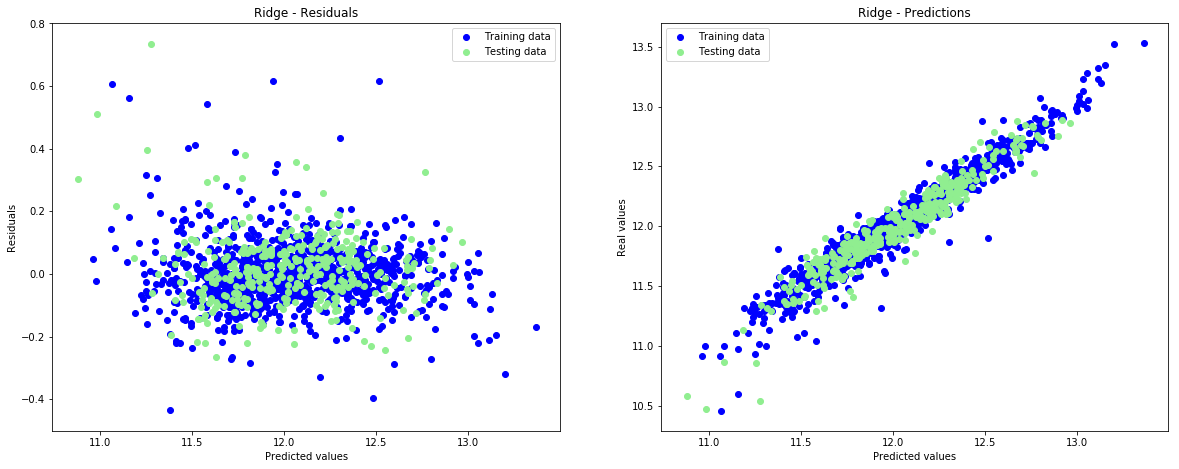

In [36]:
y_train_pred = ridge.predict(X_scaled)
y_test_pred = ridge.predict(X_hold_scaled)
plt.figure(figsize=(20, 7.5))
  
# Plot residuals
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, y_train_pred - np.log(y), c='blue', label='Training data')
plt.scatter(y_test_pred, y_test_pred - np.log(y_holdout), c='lightgreen', label='Testing data')
plt.title('Ridge - Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()

# Plot predictions
plt.subplot(1, 2, 2)
plt.scatter(y_train_pred, np.log(y), c='blue', label='Training data')
plt.scatter(y_test_pred, np.log(y_holdout), c='lightgreen', label='Testing data')
plt.title('Ridge - Predictions')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend()
plt.show()  

We seem to be capturing the general trends fairly closely. I get the sense that more data would have been very helpful in this case.

# LASSO

In [37]:
lasso = LassoCV(alphas=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 30, 40, 50]).fit(X_scaled, np.log1p(y))
print('Lasso')
print('\nCV-determined best alpha: {0}\n'.format(lasso.alpha_))
print('CV training RMSE: {0}\n'.format(np.sqrt(-cross_val_score(lasso, X_scaled, np.log1p(y), scoring='neg_mean_squared_error', cv=5)).mean()))
print('Testing RMSE: {0}'.format(np.sqrt(mean_squared_error(np.log1p(y_holdout), lasso.predict(X_hold_scaled))).round(4)))

Lasso

CV-determined best alpha: 0.001

CV training RMSE: 0.12352450470834689

Testing RMSE: 0.1166


### LASSO mean-squared error on testing set: 0.1166
So far Ridge has narrowly outperformed LASSO regression, but only by about 2 thousandths. Next up, Elastic Net, combining both Ridge and LASSO regression.

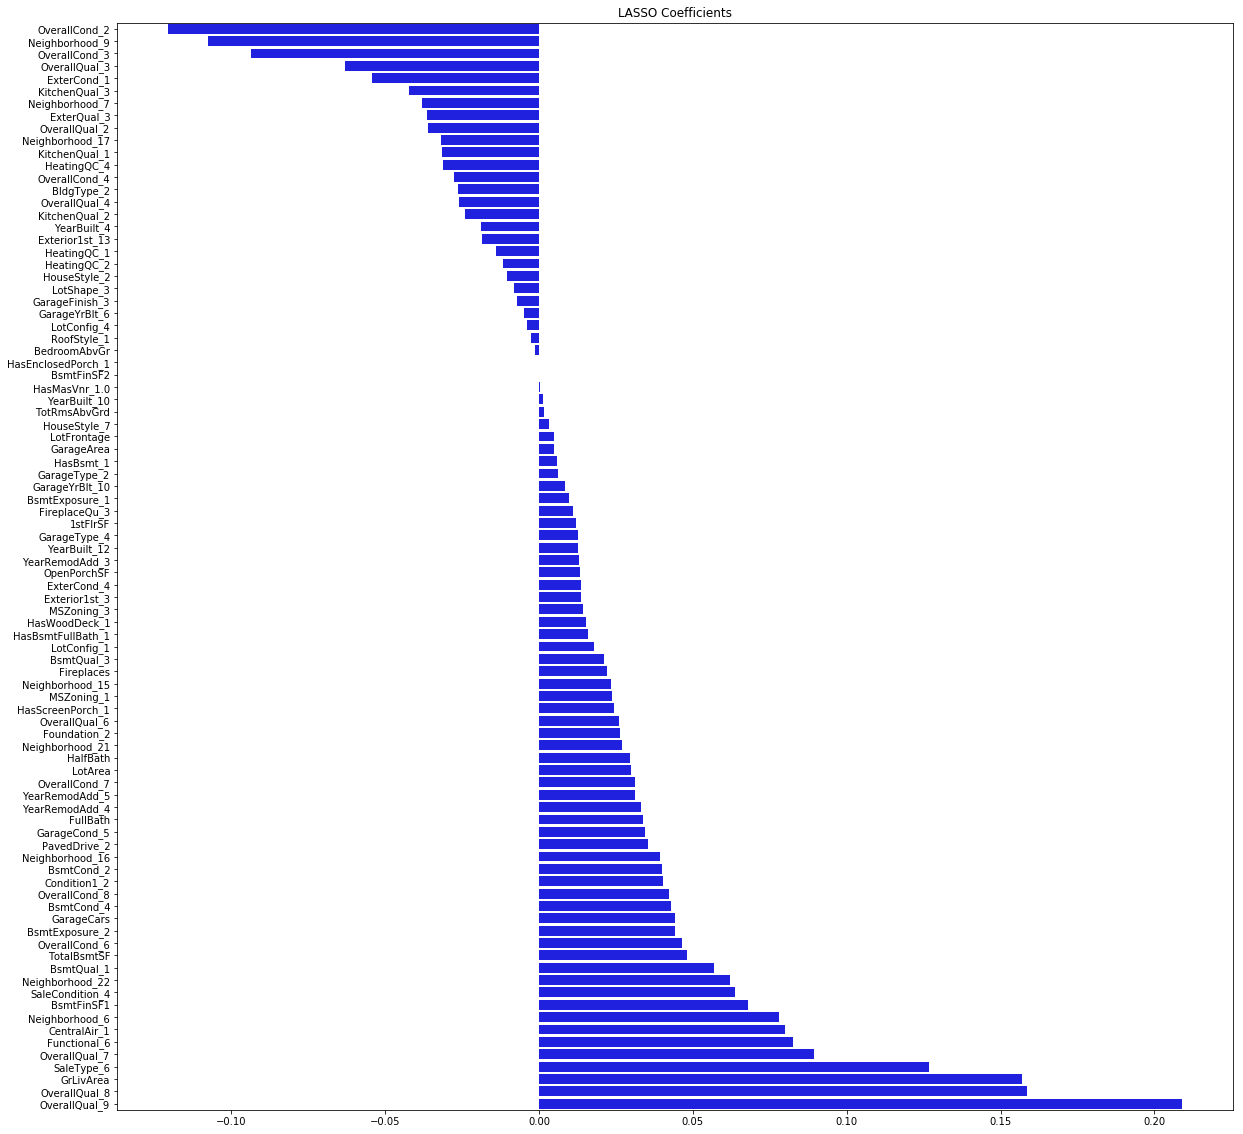

In [38]:
lasso_coef = pd.Series(lasso.coef_, index=X_scaled.columns).sort_values()
plt.figure(figsize=(20, 20))
plt.title('LASSO Coefficients')
sns.barplot(x=lasso_coef[lasso_coef != 0], y=lasso_coef[lasso_coef != 0].index, color='b')

In [39]:
pd.Series(lasso_coef[lasso_coef == 0])

Heating_1         0.0
Exterior2nd_10   -0.0
Exterior2nd_9    -0.0
Heating_2        -0.0
Heating_3        -0.0
Heating_4        -0.0
Heating_5         0.0
Exterior2nd_7     0.0
BsmtFinType2_6    0.0
Exterior2nd_6     0.0
Exterior2nd_5     0.0
Exterior2nd_4    -0.0
HeatingQC_3       0.0
Exterior2nd_3     0.0
Exterior2nd_2    -0.0
Exterior2nd_1    -0.0
Electrical_1     -0.0
Exterior2nd_8    -0.0
Exterior2nd_11   -0.0
BsmtFinType2_4    0.0
ExterQual_2       0.0
ExterCond_2       0.0
ExterCond_3      -0.0
ExterQual_1      -0.0
Foundation_1      0.0
Foundation_3     -0.0
Foundation_4      0.0
Foundation_5     -0.0
BsmtQual_2       -0.0
BsmtQual_4       -0.0
                 ... 
YearBuilt_9       0.0
Exterior1st_2    -0.0
Exterior1st_1    -0.0
RoofMatl_7        0.0
YearBuilt_11      0.0
RoofMatl_6        0.0
RoofMatl_5       -0.0
RoofMatl_4       -0.0
YearBuilt_13      0.0
RoofMatl_3        0.0
RoofMatl_2        0.0
RoofStyle_5       0.0
RoofStyle_4       0.0
YearRemodAdd_1   -0.0
RoofStyle_

As we can see, a huge chunk of our variables, particularly categorical variables, didn't prove themselves useful.

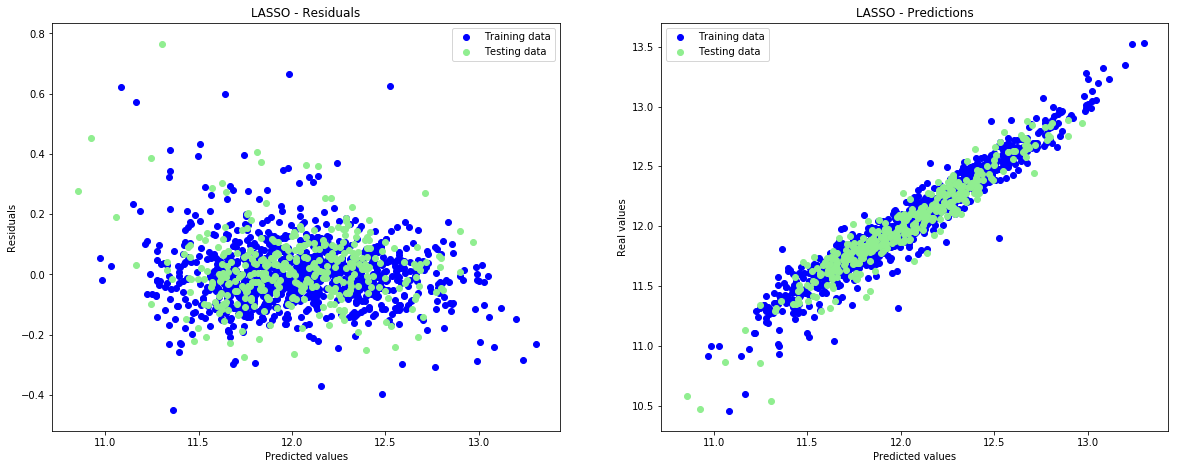

In [40]:
y_train_pred = lasso.predict(X_scaled)
y_test_pred = lasso.predict(X_hold_scaled)
plt.figure(figsize=(20, 7.5))
  
# Plot residuals
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, y_train_pred - np.log(y), c='blue', label='Training data')
plt.scatter(y_test_pred, y_test_pred - np.log(y_holdout), c='lightgreen', label='Testing data')
plt.title('LASSO - Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()

# Plot predictions
plt.subplot(1, 2, 2)
plt.scatter(y_train_pred, np.log(y), c='blue', label='Training data')
plt.scatter(y_test_pred, np.log(y_holdout), c='lightgreen', label='Testing data')
plt.title('LASSO - Predictions')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend()
plt.show()  

# Elastic Net

In [41]:
elastic_net = ElasticNetCV(l1_ratio=np.arange(0.001, 1.0, 0.0499), alphas=np.arange(0.001, 1.0, 0.0499), random_state=10).fit(X_scaled, np.log1p(y))
print('Elastic Net')
print('\nCV-determined best alpha: {0}'.format(elastic_net.alpha_))
print('CV-determined best l1 ratio: {0}\n'.format(elastic_net.l1_ratio_))
print('CV training RMSE: {0}'.format(np.sqrt(-cross_val_score(elastic_net, X_scaled, np.log1p(y), scoring='neg_mean_squared_error', cv=5)).mean()))
print('Testing RMSE: {0}'.format(np.sqrt(mean_squared_error(np.log1p(y_holdout), elastic_net.predict(X_hold_scaled))).round(4)))

Elastic Net

CV-determined best alpha: 0.001
CV-determined best l1 ratio: 0.4002

CV training RMSE: 0.12142846232205562
Testing RMSE: 0.1137


### Elastic Net mean-squared error on testing set: 0.1137
It looks like Elastic Net is indeed the best of both LASSO and Ridge, beating out both models. We've found our best model.

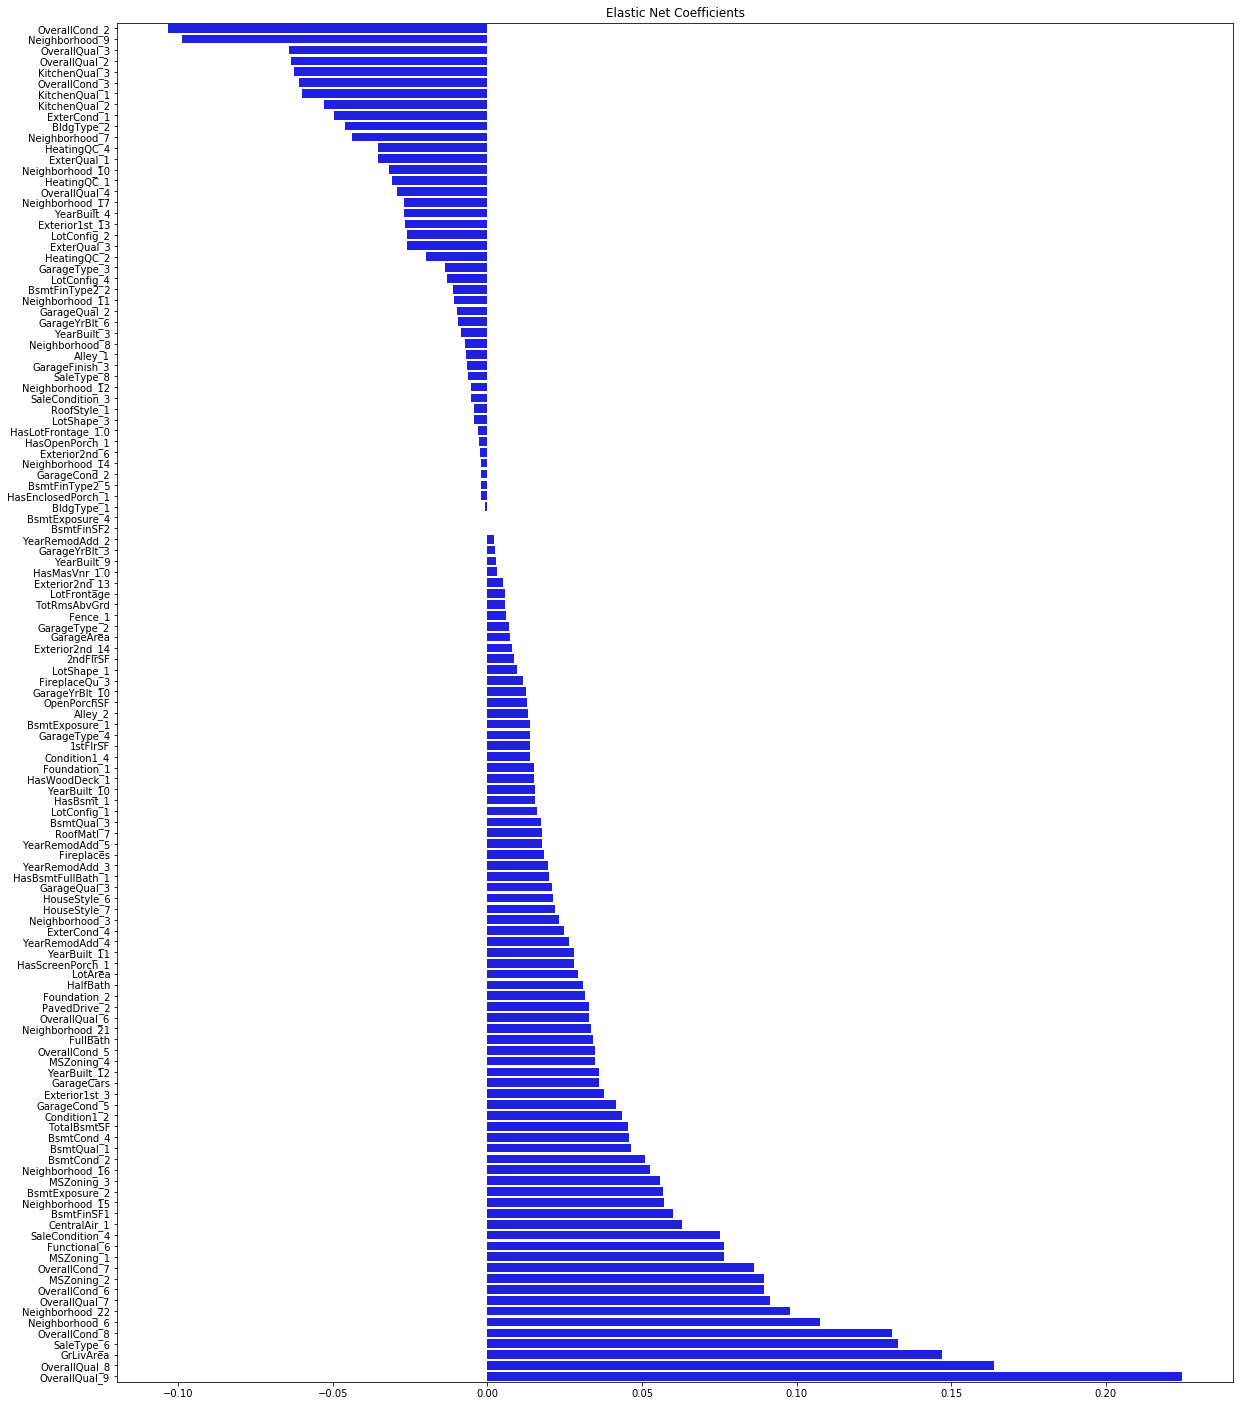

In [42]:
en_coef = pd.Series(elastic_net.coef_, index=X_scaled.columns).sort_values()
plt.figure(figsize=(20, 25))
plt.title('Elastic Net Coefficients')
sns.barplot(x=en_coef[en_coef != 0], y=en_coef[en_coef != 0].index, color='b')

In [43]:
pd.Series(en_coef[en_coef == 0])

BsmtFinType2_4     0.0
HeatingQC_3        0.0
Exterior2nd_3     -0.0
BsmtFinType2_6     0.0
Heating_1         -0.0
Heating_5          0.0
Heating_2          0.0
Heating_3         -0.0
Heating_4         -0.0
Exterior2nd_1      0.0
Exterior2nd_2      0.0
Exterior2nd_10     0.0
BsmtFinType2_1     0.0
Exterior2nd_11    -0.0
Exterior2nd_12     0.0
Exterior2nd_15    -0.0
Exterior2nd_8     -0.0
ExterQual_2       -0.0
Exterior2nd_7      0.0
ExterCond_2        0.0
ExterCond_3       -0.0
BsmtFinType2_3     0.0
Foundation_3       0.0
Foundation_5      -0.0
BsmtQual_2        -0.0
Exterior2nd_5      0.0
Exterior2nd_4     -0.0
BsmtQual_4        -0.0
BsmtCond_1        -0.0
Exterior2nd_9     -0.0
                  ... 
Neighborhood_5     0.0
Neighborhood_13    0.0
Neighborhood_18   -0.0
Neighborhood_19   -0.0
Neighborhood_20    0.0
Neighborhood_23   -0.0
Neighborhood_24    0.0
Condition1_1      -0.0
YearBuilt_7        0.0
YearBuilt_8       -0.0
BldgType_3        -0.0
RoofMatl_5        -0.0
YearRemodAd

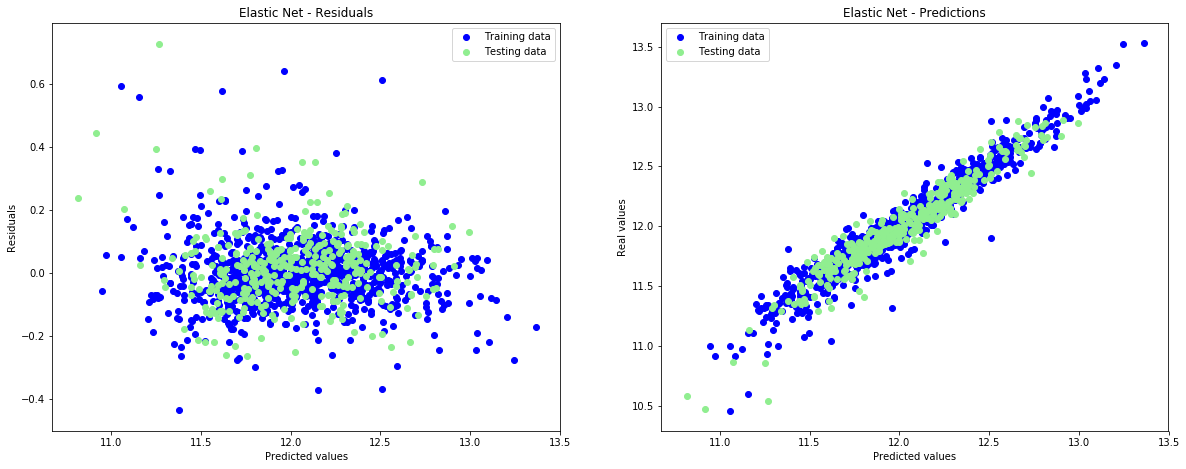

In [44]:
y_train_pred = elastic_net.predict(X_scaled)
y_test_pred = elastic_net.predict(X_hold_scaled)
plt.figure(figsize=(20, 7.5))
  
# Plot residuals
plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, y_train_pred - np.log(y), c='blue', label='Training data')
plt.scatter(y_test_pred, y_test_pred - np.log(y_holdout), c='lightgreen', label='Testing data')
plt.title('Elastic Net - Residuals')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()

# Plot predictions
plt.subplot(1, 2, 2)
plt.scatter(y_train_pred, np.log(y), c='blue', label='Training data')
plt.scatter(y_test_pred, np.log(y_holdout), c='lightgreen', label='Testing data')
plt.title('Elastic Net - Predictions')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend()
plt.show()   

# Conclusions
* From start to finish this was the fastest I've ever completed a project. I'm very glad I was able to get this additional experience using regression sooner rather than later.
* I hope to complete at least one more project before graduation in May. There are so many subjects I want to take on, such as text mining and clustering. I'm also trying to experiment more and more with R. I would like to have at least one of my future projects completed in R instead of Python.